# 머신러닝 기초
- RDKIT과 MOL2VEC 소개

[참조(Kaggle)](https://www.kaggle.com/code/vladislavkisin/tutorial-ml-in-chemistry-research-rdkit-mol2vec/notebook)

# 배경지식

- 분자의 일반적인 속성들로부터 분자의 물리적, 화학적, 생화학적인 특성을 예측하는 것이 필요하다.

- 원하는 특성을 가지는 '가상의' 분자의 분자식이나 3차원 구조를 예측하는 것이 필요하다

- 이러한 작업을 QSPR (quantitative structure-property relationship) 또는 QSAR (quantitative structure-activity relationship) 문제라고 한다

- 전통적으로는 화학적, 물리학적, 수학적인 논리(이론)에 근거해서 이러한 문제를 풀었다 - 이러한 방법은 계산량이 많이 필요한 문제와 정확도 면에서 한계가 있었다

- 이를 데이터기반, 머신러닝 기반으로 해결하는 기술이 널리 도입되고 있다
 - 머신러닝(machine learning) 기반의 방식은 인공지능(artificila intelligence) 방식이라고도 불린다

# 화학 데이터의 표현형

- 화학 분야에서 머신러닝을 도입하려면 분자나 단백질 등을 가장 적절하게 표현하여 컴퓨터가 입력으로 사용할 수 있는 데이터 표현법(representation)을 찾아야 한다

- 표현식은 분자의 고유한 특성 정보를 가능한 잘 표현할 수 있어야 한다

## SMILES
- Simplified Molecular Input Line Entry System
- 가장 간단한 분자 표현 방식이다. 알파벳으로 된 원자 기호를 사용한다
- Single bonds는 생략하고 double, triple, quadruple bond는 각각 *'='*, *'#'*, *'$'* 로 표현한다
- 링구조는 시작과 끝 원자에 숫자를 붙인다
- 아로마틱 원자는 소문자로 표현한다: b, c, n, o, p, s 등

- 예:

<img src="http://www.daylight.com/dayhtml/doc/theory/theory4.gif"/>

- 장점:
 - 읽기 쉽고 작성하기도 쉽다.
 - 문자열 처리 방식으로 처리가 가능하다

- 단점:
 - 분자의 공간적인 정보는 표현하지 못한다
 - 동일한 분자에 대해서도 다양한 표현법이 있을 수 있다

## **Mol file**

- SMILE은 한 줄의 스트링(문자열)로 분자를 표현하나, Mol 파일은 분자에 대한 상세한 정보를 파일로 표현한다: atoms, bonds, connectivity, 좌표정보 등을 포함한다

- MOL 파일 예는 아래와 같다

<img src="https://chem.libretexts.org/@api/deki/files/112699/MOL_FILE_1.png?revision=1&size=bestfit&width=777&height=601"/>

- 장점:
 - 공간 정보를 포함한다(2D or 3D)
 - 가 분자에 대해서 동일한 하나의 표현이 가능하다

단점:
- SMILES에 비해서 크기가 크다
- 개인이 작성하기 어렵고 필요한 특성정보를 컴퓨터가 인식하게 하려면 데이터 처리가 필요하다

## **Coloumb matrices 등 양자역학적 표현법**


- 분자 특성을 Schrödinger 방정식으로부터 추출할 수 있다는 가정에 출발
- 원자 좌표값과 전하량 등을 고려하여 계산한다

- 장점:
 - 수학 및 화학적으로 명확한 표현법을 제공

- 단점:
 - 계산량이 많으며 관련 데이터를 다량 확보하기기 어렵다


# RDkit을 이용하여 SMILES와 MOL 표현형 다루기

- RDKit은 화학물질의 여러 특성을 파악하고, 표현형을 바꾸고, 특성을 예측하는데 널리 사용되는 cheminformatics와 머신러닝용 패키지이다

# import

In [10]:
!pip -q install rdkit-pypi
# !pip install deepchem
# !conda install -y -c rdkit rdkit;

     |████████████████████████████████| 29.5 MB 1.2 MB/s 


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import seaborn as sns
from rdkit import Chem 
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole     # 화면에 출력하기 위한 옵션
IPythonConsole.ipython_useSVG=True
%config InlineBackend.figure_format = 'retina' # 레티나 디스플레이 사용
from rdkit.Chem import Draw

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report




# 데이터

- 소분자 유기화합물의 lipophilicity 데이터 사용

- **Lipophilicity** 는 화합물이 lipids, oils 등 비극성 용매에 용해되는 물리적 특성을 나타낸다

- 이는 분배 계수 distribution coefficent P로 표현된다
 - 물과 옥탄올에 대한 평형상태의 용해농도의 비률로 표현된다
 - P 값이 클수록 지질 친화성이 큰 것을 나타낸다 (보통 log10P를 사용한다)
 - 실험적으로 이 값을 구하려면 많은 노력이 필요하다. 


In [2]:
# 데이터 다운로드
df= pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/logP_dataset.csv', names=['smiles', 'logP'])
print(df.shape)
df[:3]

(14610, 2)


,smiles,logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3


## smiles 표현형으로부터 mol 객체를 얻는다
- Chem.MolFromSmiles() 함수를 이용한다

In [3]:
from rdkit import Chem 
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 
print(type(df['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


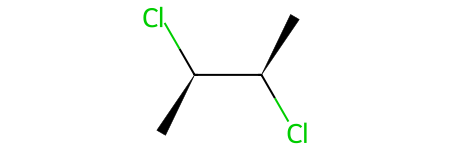

In [4]:
df.mol[0]

### 분자 시각화

- rdkit.Chem.Draw를 사용하여 mol 객체를 시각화할 수 있다
- Draw.MolsToGridImage()함수 사용

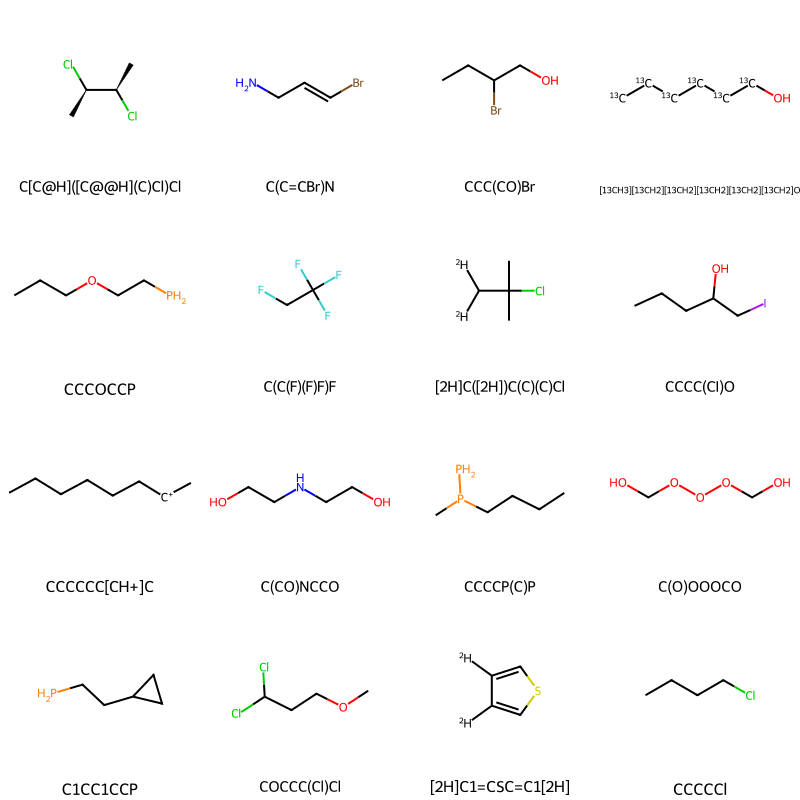

In [5]:
from rdkit.Chem.Draw import IPythonConsole     # 화면에 출력하기 위한 옵션
IPythonConsole.ipython_useSVG=True
%config InlineBackend.figure_format = 'retina' # 레티나 디스플레이 사용
from rdkit.Chem import Draw

# 16개를 한번에 그려보겠다
mols = df['mol'][:16]
Draw.MolsToGridImage(mols, molsPerRow=4, useSVG=True, legends=list(df['smiles'][:16].values))

### 분자 정보보기

- Chem 모듈에서 다양한 정보 추출 함수를 제공한다
- mol 객체로부터 분자를 구성하는 원자수를 얻으려면 다음과 같은 함수를 사용하면 된다
 - ***GetNumAtoms()***
 - ***GetNumHeavyAtoms()***

In [6]:
# AddHs() mol 객체에 수소 원자를 추가로 표시한다
# GetNumAtoms() 모든 원자 수 얻기
# GetNumHeavyAtoms() 분자량이 1 이상인 분자의 원자수 얻기


df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
df[:3]

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x13f365100>,14,6
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x13f470340>,11,5
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x13f4703a0>,15,6


- 원자수가 목적변수(logP)와 어떤 관계가 있는지 산포로도 확인하겠다

In [7]:
df.shape

(14610, 5)

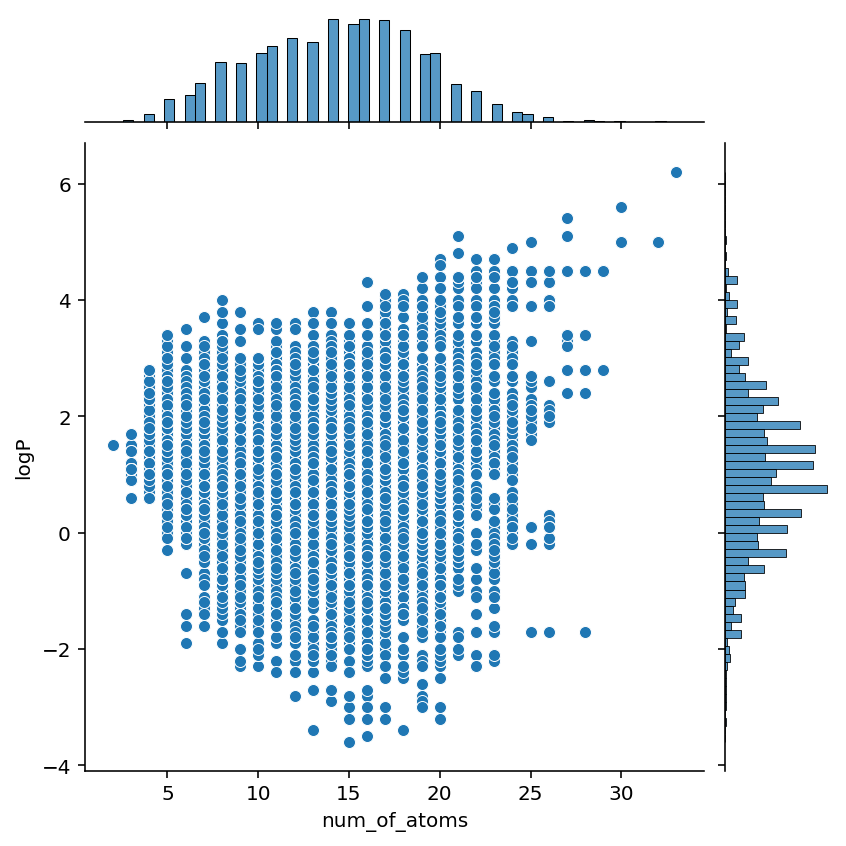

In [8]:
import seaborn as sns
sns.jointplot(df.num_of_atoms, df.logP)
plt.show()

## 특성 추가
- 각 원자별 갯수를 특성으로 추가하겠다
- 이를 위해서 GetSubstructMatches()를 사용하여 특정한 패턴이 들어있는지를 찾아낼 수 있다

In [9]:
# 탄소 패턴을 지정한다
c_patt = Chem.MolFromSmiles('C')

# 이 패턴이 들어있는 곳을 찾는다. 패턴의 수를 세면 탄소 원자가 몇개 들어있는지 알 수 있다
print(df['mol'][0].GetSubstructMatches(c_patt))

((0,), (1,), (2,), (3,))


In [10]:
# 임의의 패턴(원자)를 포함하는 수를 찾는 함수 정의
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

In [11]:
df[:3]

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x13f365100>,14,6,4,0,0,2
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x13f470340>,11,5,3,0,1,0
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x13f4703a0>,15,6,4,1,0,0


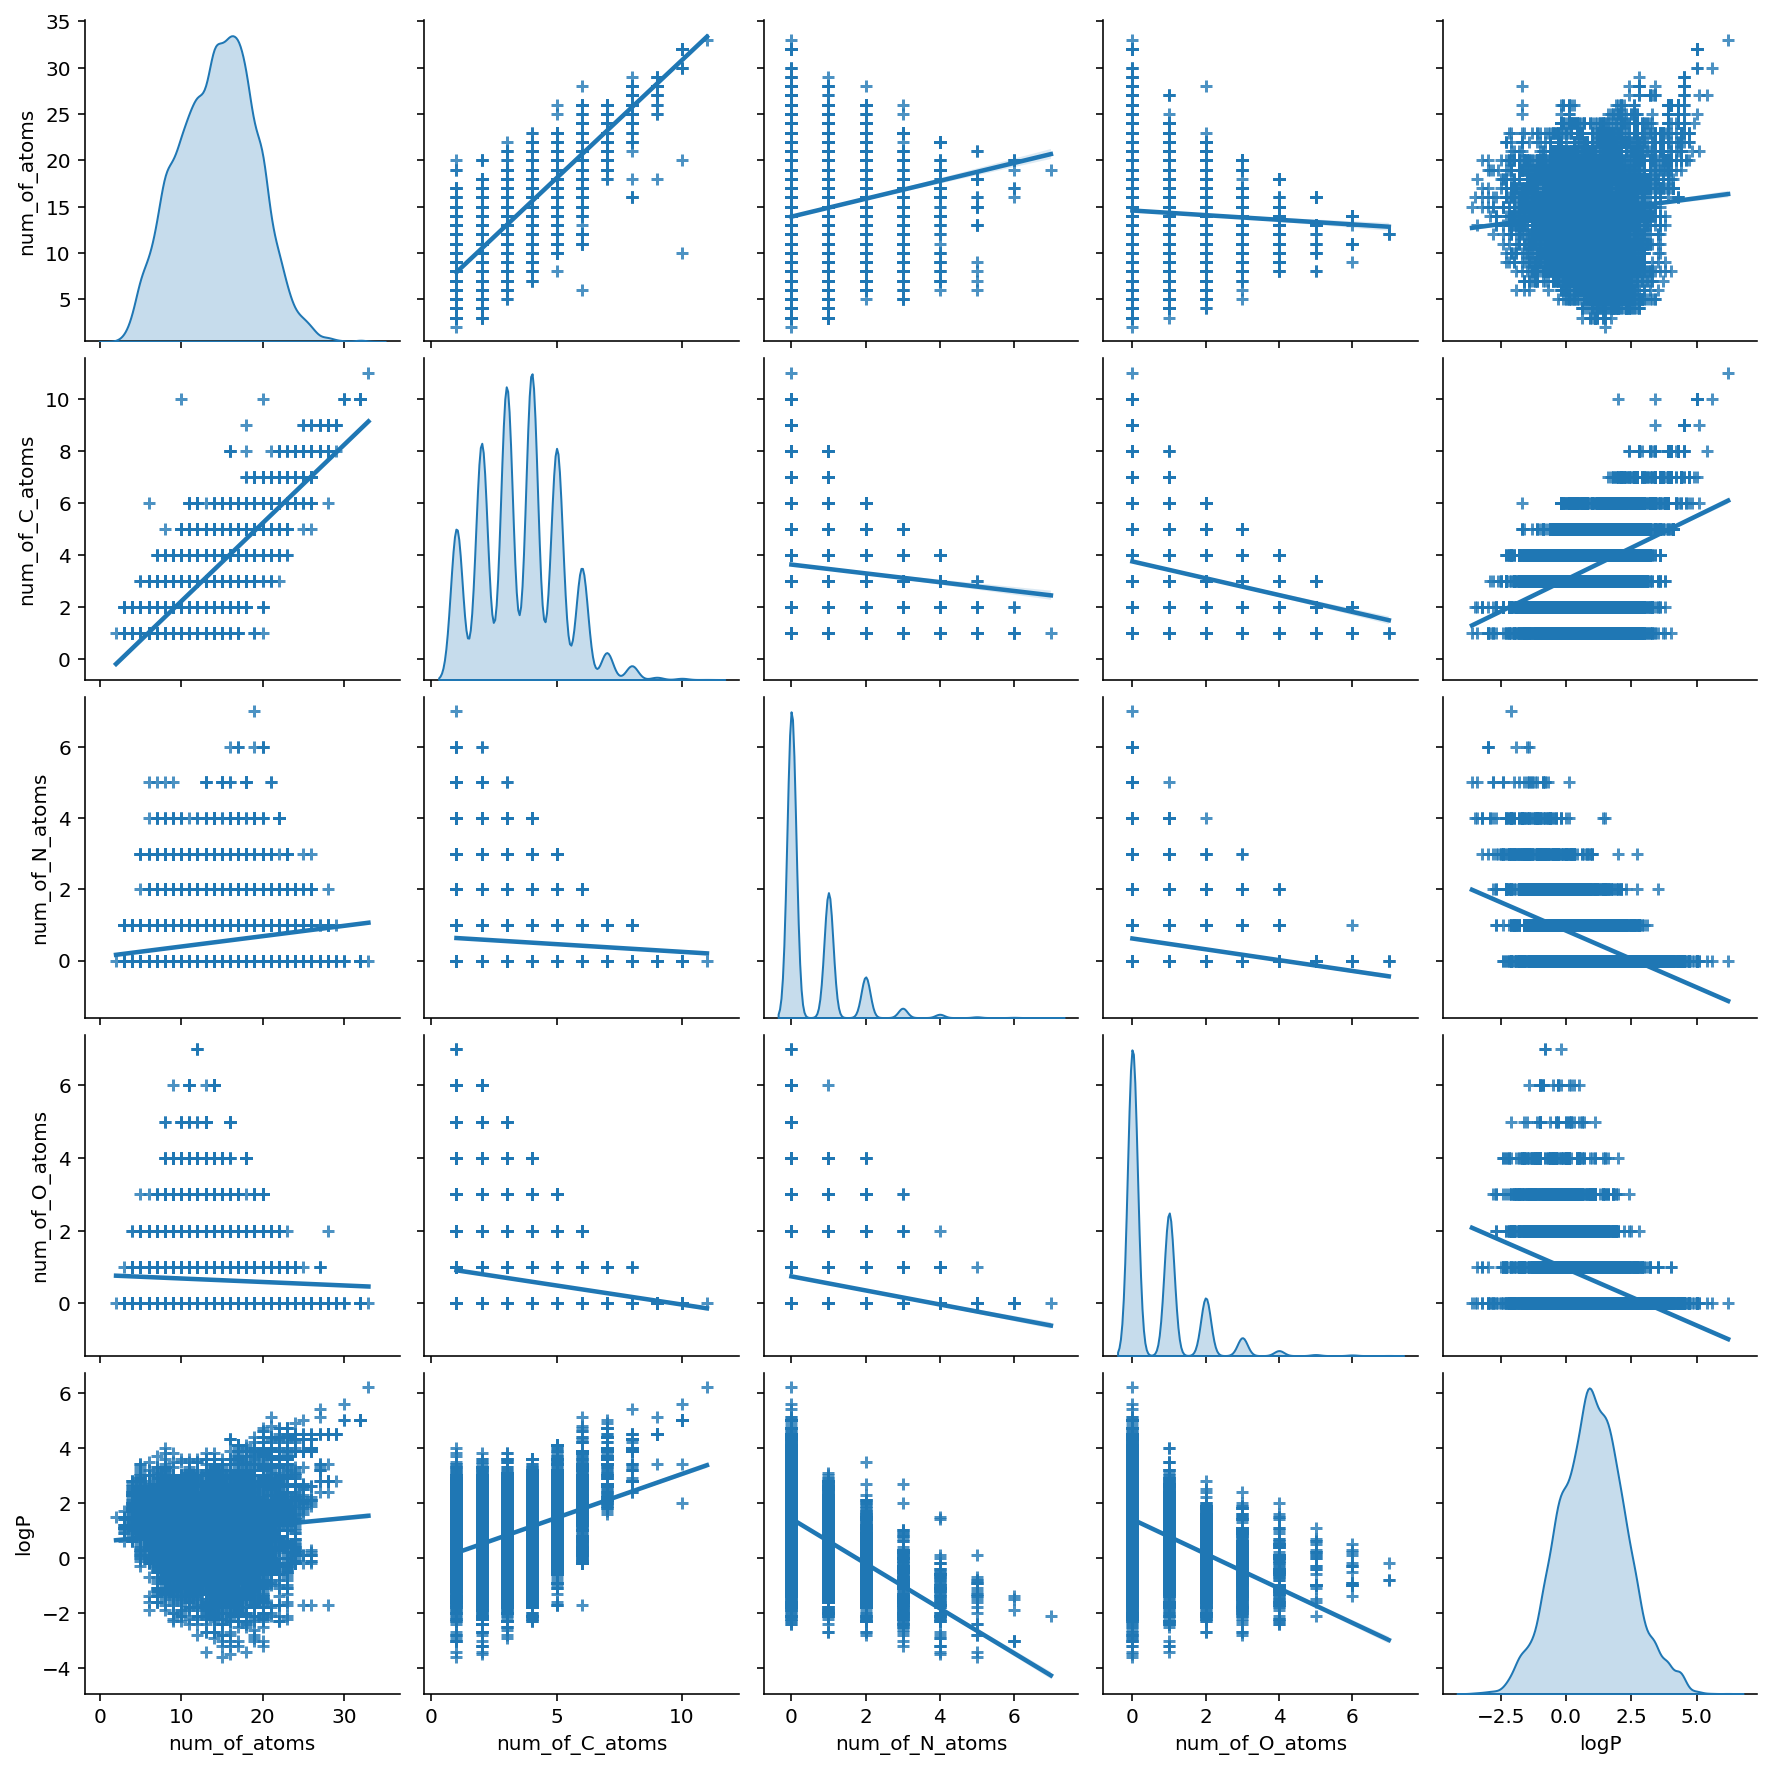

In [12]:
sns.pairplot(df[['num_of_atoms','num_of_C_atoms','num_of_N_atoms', 'num_of_O_atoms', 'logP']], 
             diag_kind='kde', kind='reg', markers='+')
plt.show()

- 위 그래프의 맨 아래 행을 보면 logP와 특정 원자수와의 관계를 파악할 수 있다.

# 회귀 모델

In [13]:
df.shape
df_pre = df.copy()

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 특성 컬럼을 선택하여 X를 만들고 목적변수를 정의한다
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)

# 훈련과 검증 데이터를 나눈다

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)


Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')


- 모델의 성능을 평가하는 함수정의

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_reg(model, X_test, y_test, N=100):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction, squared=False)
    R2 = r2_score(y_test, prediction)
    max_err = np.abs(y_test - prediction).max()
    
    print('R2:', round(R2,4))
    print('MAE:', round(mae, 4))
    print('MSE:', round(mse,4))
    print('Max error:', round(max_err, 4))
    if N > 0:
      plt.figure(figsize=(10, 6))
      plt.plot(prediction[:N], ".r-", label="prediction", linewidth=1.0)
      plt.plot(y_test[:N], '.b-', label="actual", linewidth=1.0)
      plt.legend()
      plt.ylabel('logP')
      plt.show()
    

R2: 0.6838
MAE: 0.5694
MSE: 0.7292
Max error: 3.0418


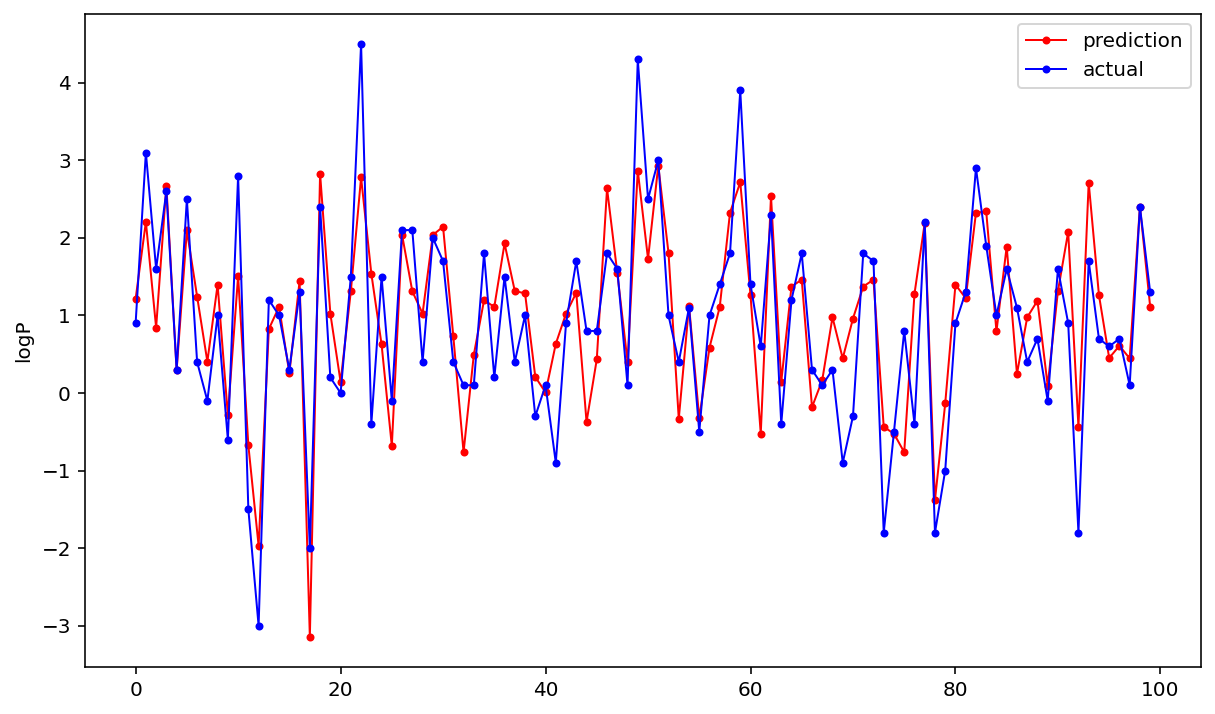

In [16]:
# 모델 학습 및 성능 평가
lin = LinearRegression()
lin.fit(X_train, y_train)
eval_reg(lin, X_test, y_test)

## 회귀모델의 성능지표 설명

## 추가 정보보기
- 분자의 링정보를 보거나, 원자별로 결합 정보를 볼 수 있다
- GetRingInfo(), GetAtoms(), GetBonds() 등을 사용한다

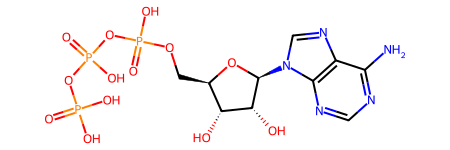

In [17]:
# 샘플 분자
m = Chem.MolFromSmiles('C1=NC2=C(C(=N1)N)N=CN2[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O)O')
m

In [18]:
# 링 갯수 보기
print('Number of rings with 1 backbone:', m.GetRingInfo().NumAtomRings(1))
print('Number of rings with 2 backbones:', m.GetRingInfo().NumAtomRings(2))

Number of rings with 1 backbone: 1
Number of rings with 2 backbones: 2


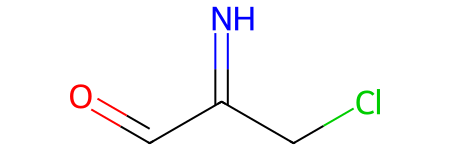

In [19]:
# 다른 분자
m = Chem.MolFromSmiles('C(=O)C(=N)CCl')
m

In [20]:
# 각 원자에 대해서 valencies 값 보기
for atom in m.GetAtoms():
    print('Atom:', atom.GetSymbol(), 'Valence:', atom.GetExplicitValence())

Atom: C Valence: 3
Atom: O Valence: 2
Atom: C Valence: 4
Atom: N Valence: 2
Atom: C Valence: 2
Atom: Cl Valence: 1


## 분자 특성 추가

- rdkit.Chem.Descriptors이 제공하는 아래의 함수들을 사용하면 다양한 분자특성들을 알 수 있다

 - TPSA() - the surface sum over all polar atoms or molecules also including their attached hydrogen atoms;
 - ExactMolWt() - 정확한 몰 중량
 - NumValenceElectrons() - number of valence electrons (may illustrate general electronic density)
 - NumHeteroatoms() - general number of non-carbon atoms

In [21]:
from rdkit.Chem import Descriptors
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

- 특성을 추가했을 때의 성능을 비교하겠다

In [22]:
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'tpsa', 'mol_w',
       'num_valence_electrons', 'num_heteroatoms'],
      dtype='object')


R2: 0.7907
MAE: 0.4625
MSE: 0.5932
Max error: 2.2606


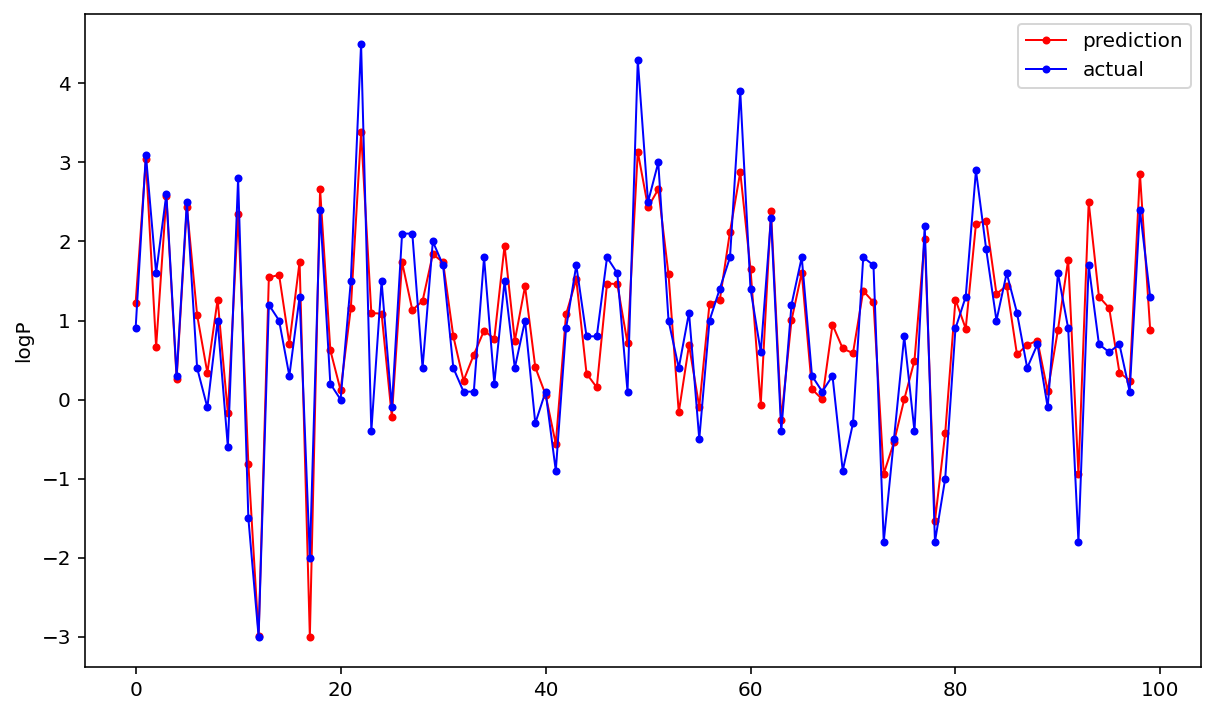

In [23]:
lin.fit(X_train, y_train)
eval_reg(lin, X_test, y_test)

In [24]:
df_descriptors = df.copy()
df_descriptors.shape

(14610, 13)

In [25]:
## 선형 모델 가중치 보기

def plot_feature_weight(feature, weight):
    # plt.figure(figsize=(5,5))
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

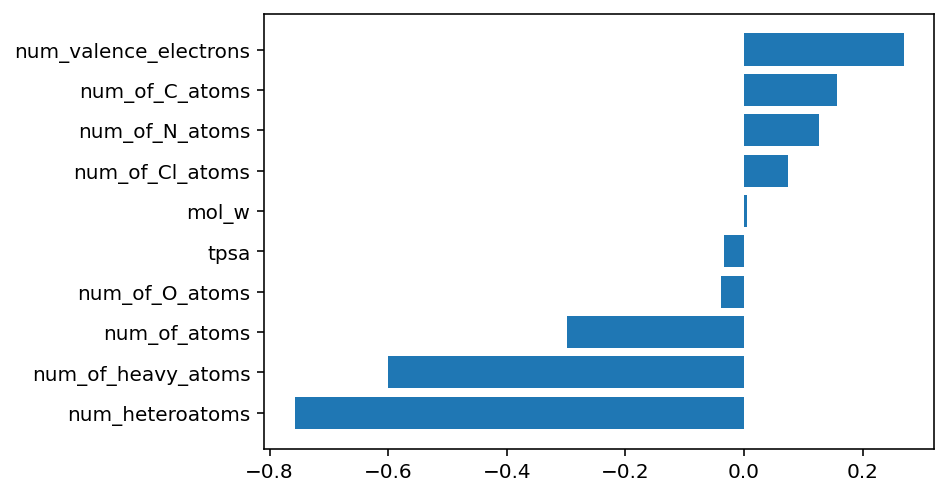

In [26]:
plot_feature_weight(train_df.columns, lin.coef_)

# 트리 모델
- 결정 트리, 랜덤포레스트

In [27]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree

In [28]:
# 최적의 트리 깊이 (max_depth)를 실험으로 찾는다
for depth in range(1,30,2):
    dtr = DecisionTreeRegressor(max_depth=depth) 
    dtr.fit(X_train, y_train) 
    print(depth, dtr.score(X_test, y_test).round(3)) 

1 0.425
3 0.682
5 0.766
7 0.81
9 0.836
11 0.852
13 0.854
15 0.868
17 0.861
19 0.862
21 0.861
23 0.86
25 0.858
27 0.861
29 0.868


In [29]:
dtr = DecisionTreeRegressor(max_depth=15) 
dtr.fit(X_train, y_train) 
eval_reg(dtr, X_test, y_test, 0)

R2: 0.8659
MAE: 0.3427
MSE: 0.4749
Max error: 2.5


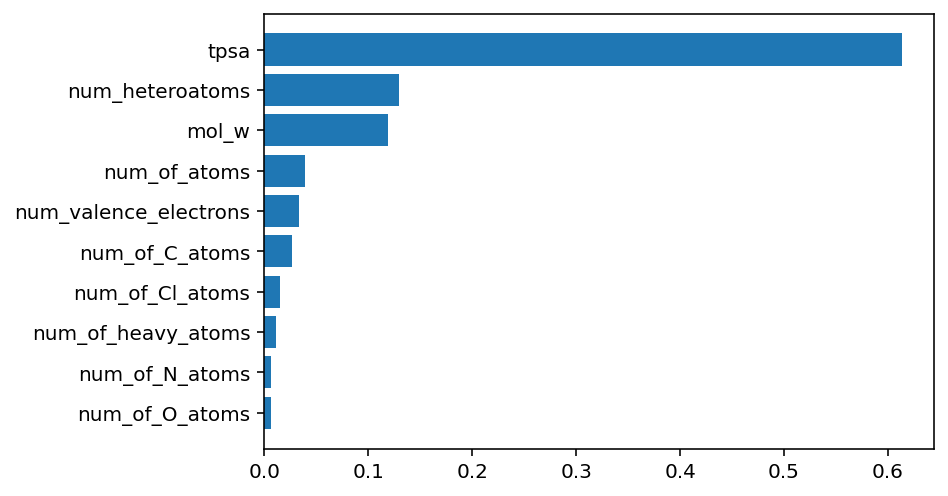

In [30]:
plot_feature_weight(train_df.columns, dtr.feature_importances_)

In [31]:
rfr = RandomForestRegressor() 
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test).round(3)


0.895

In [32]:
eval_reg(rfr, X_test, y_test, 0)

R2: 0.8947
MAE: 0.3113
MSE: 0.4207
Max error: 1.9445


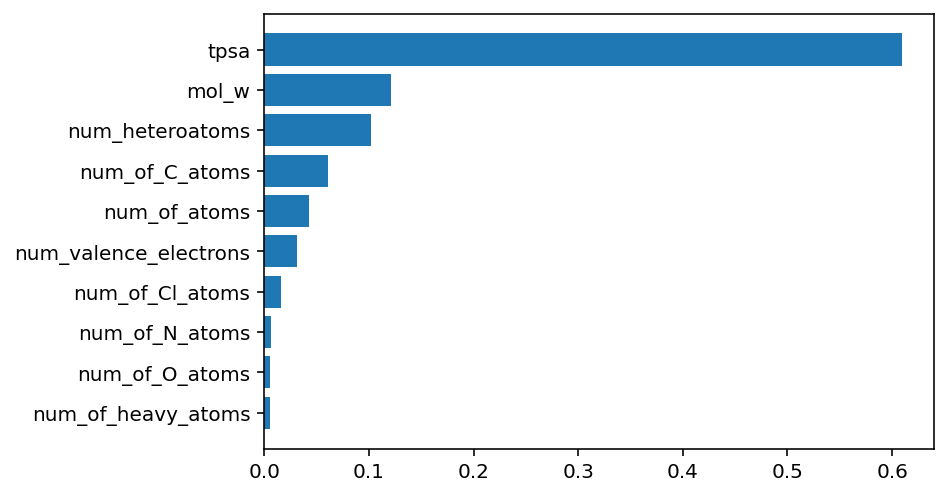

In [33]:
plot_feature_weight(train_df.columns, rfr.feature_importances_)

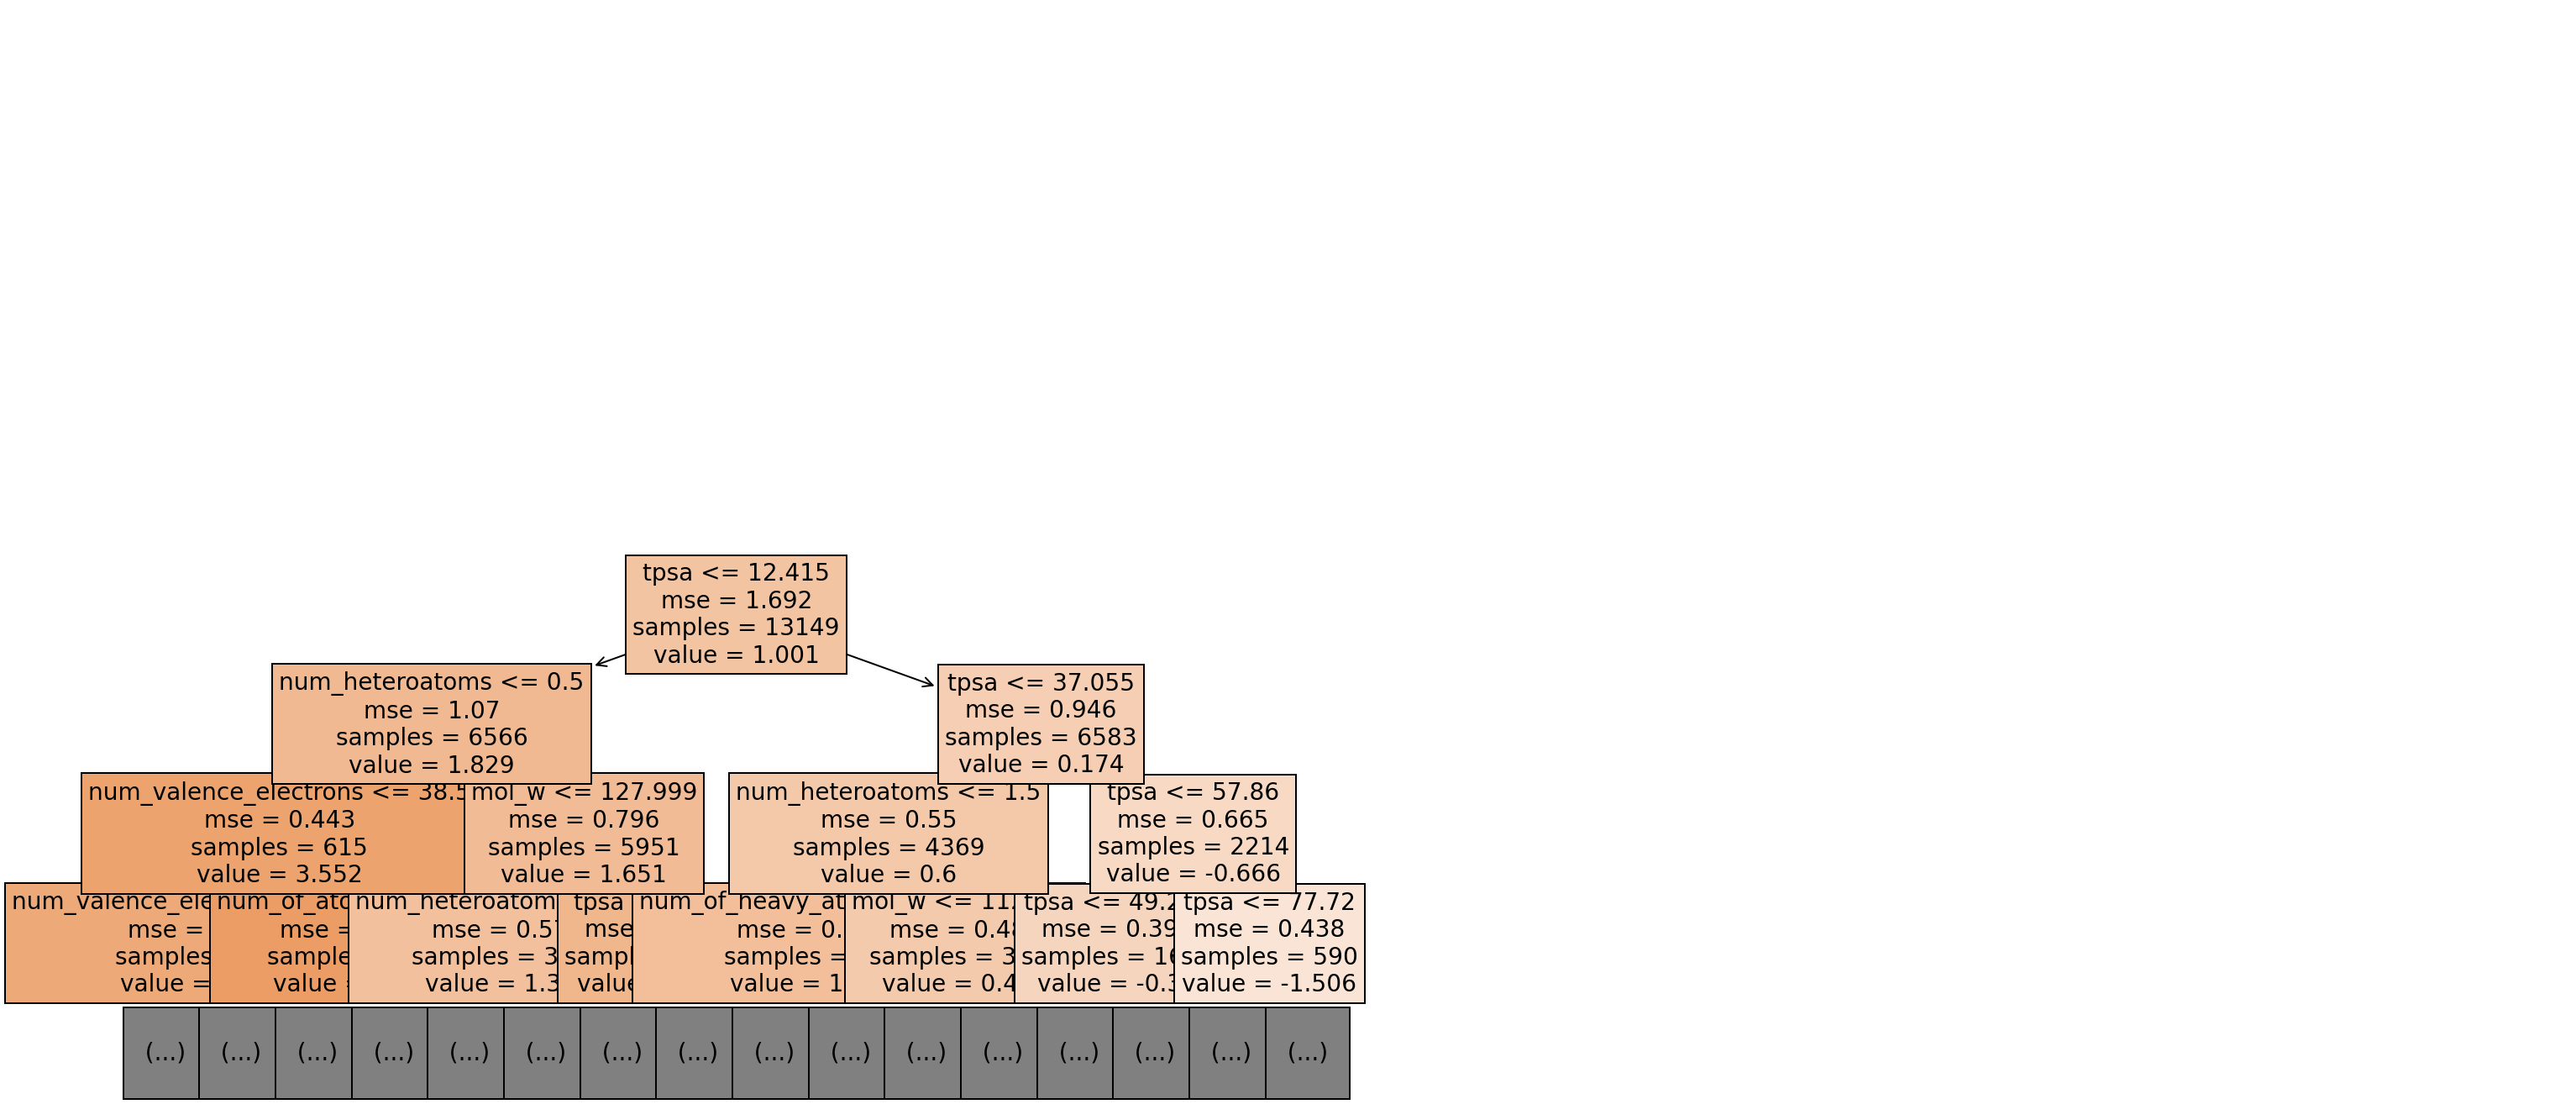

In [34]:
from sklearn import tree
import matplotlib
plt.figure(figsize=(26,12))

tree.plot_tree(dtr, fontsize=14,
              feature_names=train_df.columns,
              filled=True,
              impurity=True,
              max_depth=3)
plt.show()

# ECFP 를 특성으로 사용하는 경우

In [35]:
from rdkit.Chem import AllChem
from rdkit import DataStructs

In [36]:
def mol_2_fp(mol):
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
  fp_arr = np.zeros((1, ), dtype=np.int8)
  DataStructs.ConvertToNumpyArray(fp, fp_arr)
  return fp_arr

In [37]:
list_fp = df['mol'].apply(mol_2_fp)
ecfp = np.vstack(list_fp)
print(ecfp.shape)
ecfp[:3]

(14610, 1024)


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int8)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(ecfp, y, test_size=.1, random_state=1)

R2: 0.7905
MAE: 0.4407
MSE: 0.5935
Max error: 4.3088


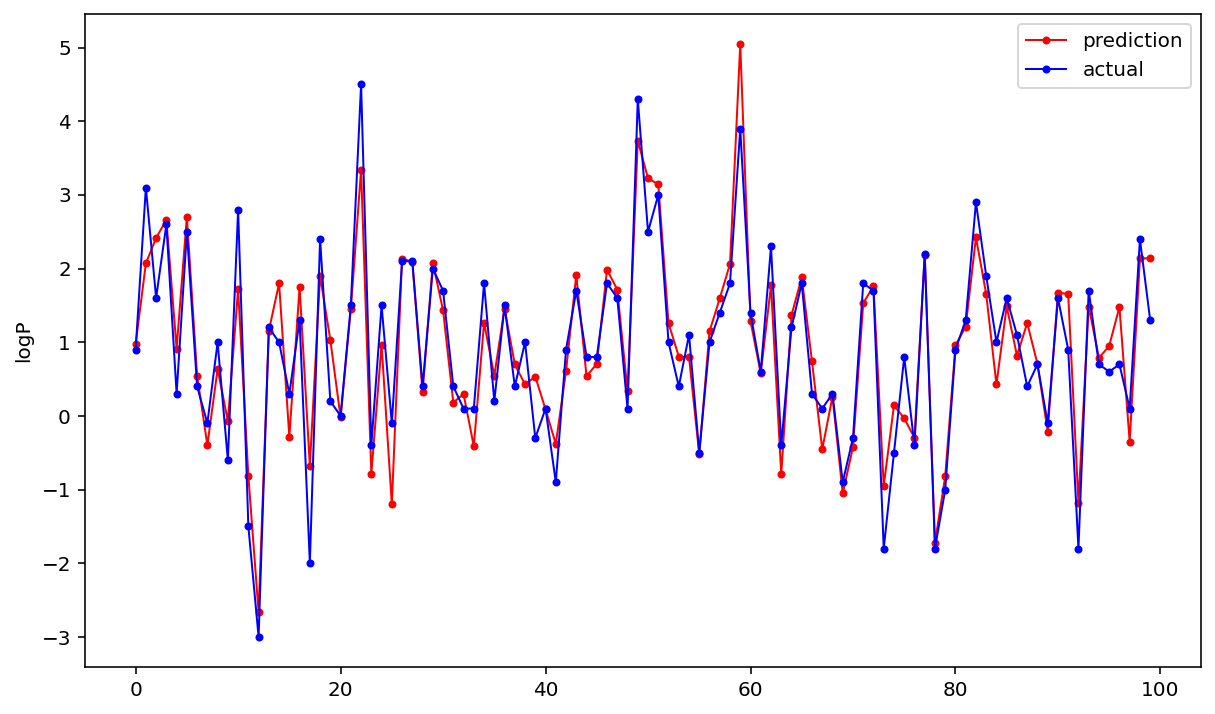

In [39]:
lin.fit(X_train, y_train)
eval_reg(lin, X_test, y_test)

## 랜덤포레스트 모델

In [40]:
rfr.fit(X_train, y_train)
eval_reg(rfr, X_test, y_test,0)

R2: 0.8519
MAE: 0.3309
MSE: 0.4991
Max error: 3.661


# Scaffold Splitter

In [173]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 16.9 MB/s 


In [41]:
import deepchem as dc
# creation of demo data set with some smiles strings
data_test= ["CC(C)Cl" , "CCC(C)CO" ,  "CCCCCCCO" , "CCCCCCCC(=O)OC" , "c3ccc2nc1ccccc1cc2c3" , "Nc2cccc3nc1ccccc1cc23" , "C1CCCCCC1" ]
Xs = np.zeros(len(data_test))
Ys = np.ones(len(data_test))
# creation of a deepchem dataset with the smile codes in the ids field
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,w=np.zeros(len(data_test)),ids=data_test)
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train,test = scaffoldsplitter.train_test_split(dataset)
train

<DiskDataset X.shape: (5,), y.shape: (5,), w.shape: (5,), ids: ['CC(C)Cl' 'CCC(C)CO' 'CCCCCCCO' 'CCCCCCCC(=O)OC' 'C1CCCCCC1'], task_names: [0]>

In [42]:
Xs = df[['num_of_atoms', 'num_of_heavy_atoms',
       'num_of_C_atoms', 'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms',
       'tpsa', 'mol_w', 'num_valence_electrons', 'num_heteroatoms']]
Ys = df['logP']
ids = df['smiles']

In [43]:
df.shape

(14610, 13)

In [44]:
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,w=np.zeros(len(Xs)),ids=ids)
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train,test = scaffoldsplitter.train_test_split(dataset)

In [45]:
train

<DiskDataset X.shape: (1326, 10), y.shape: (1326,), w.shape: (1326,), task_names: [0]>

In [46]:
test

<DiskDataset X.shape: (13284, 10), y.shape: (13284,), w.shape: (13284,), task_names: [0]>

In [47]:
lin.fit(train.X, train.y)
eval_reg(lin, test.X, test.y,0)

R2: 0.701
MAE: 0.5575
MSE: 0.7124
Max error: 3.7252


In [48]:
rfr.fit(train.X, train.y)
eval_reg(rfr, test.X, test.y,0)

R2: 0.5481
MAE: 0.6897
MSE: 0.8758
Max error: 3.8927


# mol2vec

- 분자의 구조를 임베딩 벡터로 표현하는 방법으로 Mol2vec을 사용하는 방법을 소개한다
- 자연어처리 분야에서 도입된 word2vec 알고리즘을 적용한다. 이는 문장을 구성하는 기본 단위읜 '단어(word)'의 성격이 비슷하면 서로 비슷한 값들로 구성된 고차원 벡터 공간의 점(tuple)으로 표현된다는 원리를 이용한 것이다 

- 구현 절차는 다음과 같다

- **1.** 화합물(chemical sentences)이라는 문장에서 Substructures를  단어처럼 취급한다. 
 - 한 분자는 substructures 단위로 나누어지며 하나의 단위 구조는 일정한 거리(radius)를 갖도록 한다 (원자간의 거리를 결합으로 나타내는데 예를 들어 radius = 1 이면 하나의 무거운 원자와 주변의 원자들을 나타낸다)
 - substructures는 [Morgan fingerprints](https://docs.chemaxon.com/display/docs/Extended+Connectivity+Fingerprint+ECFP)로 표현한다

- **2.** 이렇게 인코딩된 substructures에 Word2vec 알고리즘을 적용한다

- **3.** substructure 벡터들을 합하여 분자를 표현하는 벡터를 얻는다


- mol2vec을 사용하면 대량의 데이터를 사용하여, 비지도 학습을 통하여 사전학습된 임베딩 벡터를 얻을 수 있다. 
 - 20M different compounds with radius=1 for Morgan fingerprints.

In [49]:
# 패키지 설치
!pip install git+https://github.com/samoturk/mol2vec;

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Cloning https://github.com/samoturk/mol2vec to /private/var/folders/jm/d49g6yn91g54d2blmffb2zc80000gn/T/pip-req-build-8_dtwiu3
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /private/var/folders/jm/d49g6yn91g54d2blmffb2zc80000gn/T/pip-req-build-8_dtwiu3
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 1.8 MB/s eta 0:00:00
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14038 sha256=13cb24d7d02817fe902863025d1475913d9c1c68964520

We'll start from scratch with initial dataset.

In [50]:
# 데이터 다운로드, 목적 변수는 사용하지 않는다 (비지도 학습을 수행하므로)
mdf= pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/logP_dataset.csv', names=['smiles', 
                                           'target'])
target = mdf['target']
mdf.drop(columns='target',inplace=True)

## SMILES로부터 MOL 객체를 얻는다

In [51]:
mdf['mol'] = mdf['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

- 사전학습된 mol2vec model을 다운로드한다
- 이는 radius=1 for Morgan fingerprints를 사용하며 300 차원으로 임베딩되었다

In [52]:
!curl -L -o model_300dim.pkl.zip https://www.dropbox.com/s/fslivdyhkx9lvub/model_300dim.pkl.zip?dl=1

zsh:1: no matches found: https://www.dropbox.com/s/fslivdyhkx9lvub/model_300dim.pkl.zip?dl=1


In [53]:
!unzip -q model_300dim.pkl.zip

unzip:  cannot find or open model_300dim.pkl.zip, model_300dim.pkl.zip.zip or model_300dim.pkl.zip.ZIP.


In [54]:
# word2vec 모델에 로드한다
from gensim.models import word2vec
model = word2vec.Word2Vec.load('model_300dim.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'model_300dim.pkl'

- 아래의 함수들을 이용한다

- ***mol2alt_sentence()*** constructs a so-called 'molecular sentence' with desired Morgan fingerprints' radius (uses RDkit backend) where 'words' are unique substructure identifiers; 
- ***MolSentence()*** is an internal wrapper function; 
- ***sentences2vec()*** generates molecular embeddings with the help of the trained model; 
- ***DfVec()*** is an internal wrapper for embeddings' generator (attribute .vec yields aggregated vectors).  

In [14]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
print('Molecular sentence:', mol2alt_sentence(mdf['mol'][1], radius=1))
print('\nMolSentence object:', MolSentence(mol2alt_sentence(mdf['mol'][1], radius=1)))
print('\nDfVec object:',DfVec(sentences2vec(MolSentence(mol2alt_sentence(mdf['mol'][1], radius=1)), model, unseen='UNK')))

NameError: name 'mdf' is not defined

- 주어진 14610개의 분자의 표현형을 300차원의 '사전 학습된' 임베딩 벡터로 대체한다

In [ ]:
#Constructing sentences
mdf['sentence'] = mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(mdf['sentence'], model, unseen='UNK')]
X = np.array([x.vec for x in mdf['mol2vec']])
y = target.values

X.shape

(14610, 300)

- 임베딩 벡터로 표현한 경우의 모델 성능을 비교한다

In [ ]:
X.shape

(14610, 300)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)
lin.fit(X_train, y_train)
eval_reg(lin, X_test, y_test, 0)

R2: 0.8931
MAE: 0.299
MSE: 0.424
Max error: 2.7076


- 임베딩 벡터만 사용해도 성능이 우수하다
- 기존에 수집한 특성들과 임베딩 벡터를 동시에 사용해보자

In [ ]:
mdf = pd.DataFrame(X)
new_df = pd.concat((mdf, train_df), axis=1)
new_df.shape

(14610, 310)

R2: 0.9201
MAE: 0.2609
MSE: 0.3667
Max error: 1.847


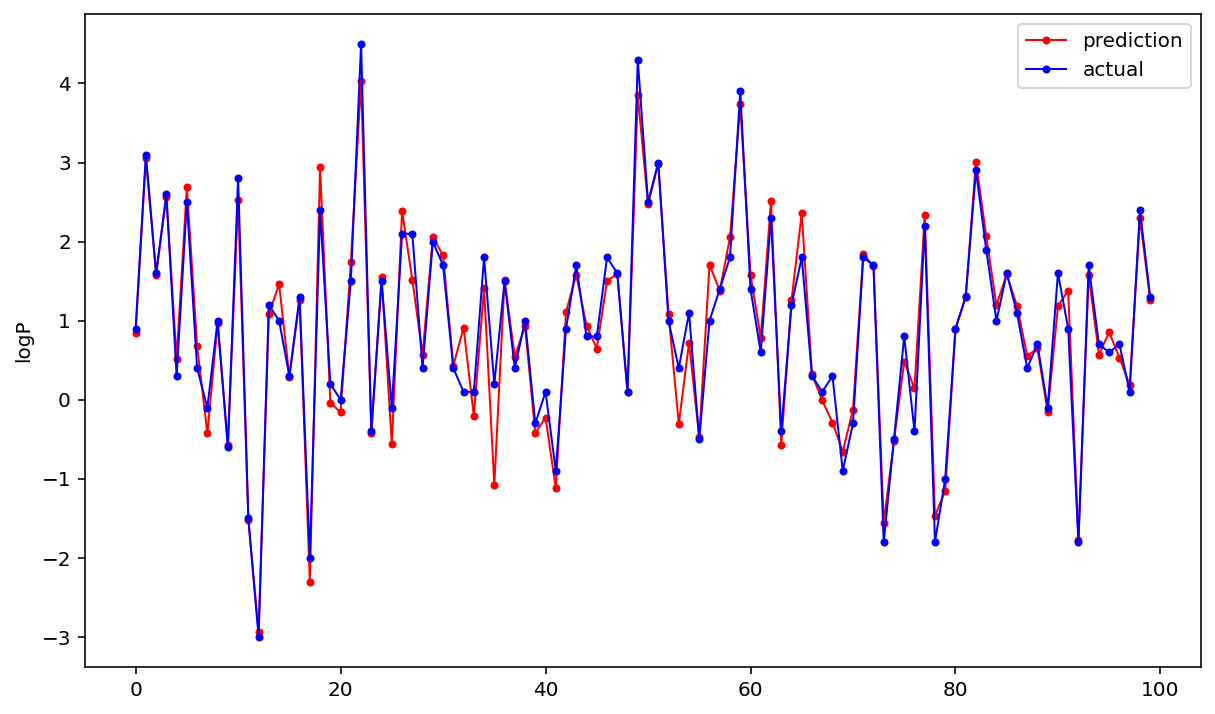

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=.1, random_state=1)
lin.fit(X_train, y_train)
eval_reg(lin, X_test, y_test)

In [ ]:
df

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7f8bbf76f800>,14,6,4,0,0,2,0.00,126.000306,38,2
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7f8bbf76f760>,11,5,3,0,1,0,26.02,134.968361,30,2
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7f8bbf76f7b0>,15,6,4,1,0,0,20.23,151.983677,38,2
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7f8bbf76f8a0>,21,7,6,1,0,0,20.23,108.124594,44,1
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7f8bbf76f8f0>,20,7,5,1,0,0,9.23,120.070402,44,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,CCC(SC)Br,2.7,<rdkit.Chem.rdchem.Mol object at 0x7f8bbde19c10>,15,6,4,0,0,0,0.00,167.960833,38,2
14606,[2H]C([2H])([C@@H](CO)O)O,-1.8,<rdkit.Chem.rdchem.Mol object at 0x7f8bbde19c60>,14,6,3,3,0,0,60.69,94.059898,38,3
14607,CC(C)NNC,0.4,<rdkit.Chem.rdchem.Mol object at 0x7f8bbde19cb0>,18,6,4,0,2,0,24.06,88.100048,38,2
14608,C[C@H]1CCC[CH]1,3.4,<rdkit.Chem.rdchem.Mol object at 0x7f8bbde19d00>,17,6,6,0,0,0,0.00,83.086075,35,0


[0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
11.0
(array([  1,  33,  59,  91,  97, 628, 649, 659, 780, 914, 925]),)


In [ ]:
print(type(fp))
print(type(fp_arr))
print(len(fp))

<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>
<class 'numpy.ndarray'>
1024


# 분류 모델

- [MoleculeNet](http://moleculenet.ai/datasets-1)에서 제공하는 HIV dataset을 사용
- 이 데이터는 4만여개의 화합물 중에 HIV를 저해하는 정도를 포함하고 있으며 다음과 같이 세가지 유형으로 나누어짐
 - confirmed inactive (CI)
 - confirmed active (CA)
 - confirmed moderately active (CM)
- 이를 이진분류를 위해서 inactive (CI)와 active (CA and CM) 두가지 클래스로 나누었다

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# 데이터 읽기
hiv = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/HIV.csv')
print(hiv.shape)
hiv.head()

(41127, 3)


,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


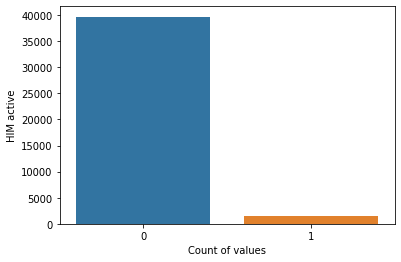

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
#Let's look at the target values count
sns.countplot(data = hiv, x='HIV_active')
plt.ylabel('HIM active')
plt.xlabel('Count of values')
plt.show()

## Mol 객체 얻기

In [8]:
# SMILES로부터 MOL를 얻는다
hiv['mol'] = hiv['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

# 특성을 추가한다
hiv['tpsa'] = hiv['mol'].apply(lambda x: Descriptors.TPSA(x))
hiv['mol_w'] = hiv['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
hiv['num_valence_electrons'] = hiv['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
hiv['num_heteroatoms'] = hiv['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

[15:20:39] WARNING: not removing hydrogen atom without neighbors
[15:20:39] WARNING: not removing hydrogen atom without neighbors


In [9]:
y = hiv.HIV_active.values
X = hiv.drop(columns=['smiles', 'activity','HIV_active', 'mol'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1)

## 분류 성능 보기

In [10]:
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

def eval_class(model, X_test, y_test):
    y_pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:,1]

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


    fpr, tpr, threshold = roc_curve(y_test, pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print('ROC AUC score:', round(roc_auc, 4))

[[7911    8]
 [ 304    3]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7919
           1       0.27      0.01      0.02       307

    accuracy                           0.96      8226
   macro avg       0.62      0.50      0.50      8226
weighted avg       0.94      0.96      0.94      8226



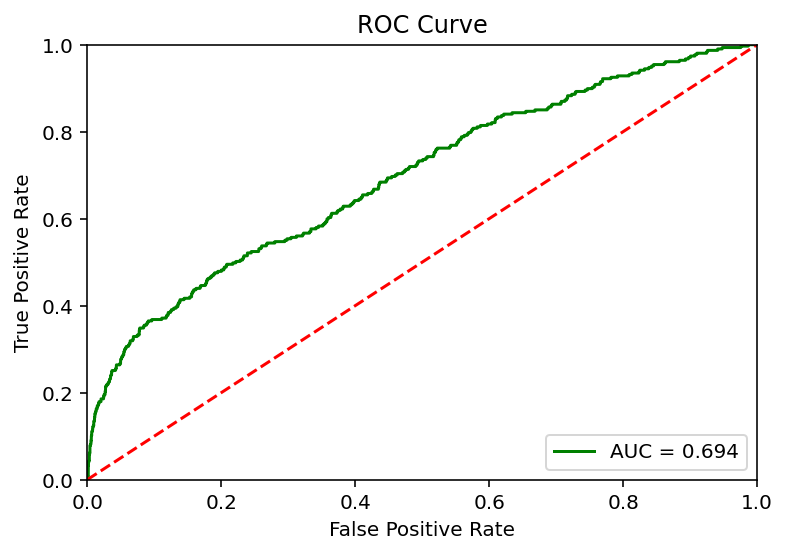

ROC AUC score: 0.6944


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

eval_class(lr, X_test, y_test)

### mol2vec을 사용하여 임베딩 벡터를 추가한 경우



In [16]:
#Constructing sentences
hiv['sentence'] = hiv.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
hiv['mol2vec'] = [DfVec(x) for x in sentences2vec(hiv['sentence'], model, unseen='UNK')]
X_mol = np.array([x.vec for x in hiv['mol2vec']])
X_mol = pd.DataFrame(X_mol)

#Concatenating matrices of features
new_hiv = pd.concat((X, X_mol), axis=1)

X_train, X_test, y_train, y_test = train_test_split(new_hiv, y, test_size=.20, random_state=1)


NameError: name 'model' is not defined

In [ ]:
new_hiv

NameError: name 'new_hiv' is not defined

[[7892   27]
 [ 244   63]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      7919
           1       0.70      0.21      0.32       307

    accuracy                           0.97      8226
   macro avg       0.84      0.60      0.65      8226
weighted avg       0.96      0.97      0.96      8226



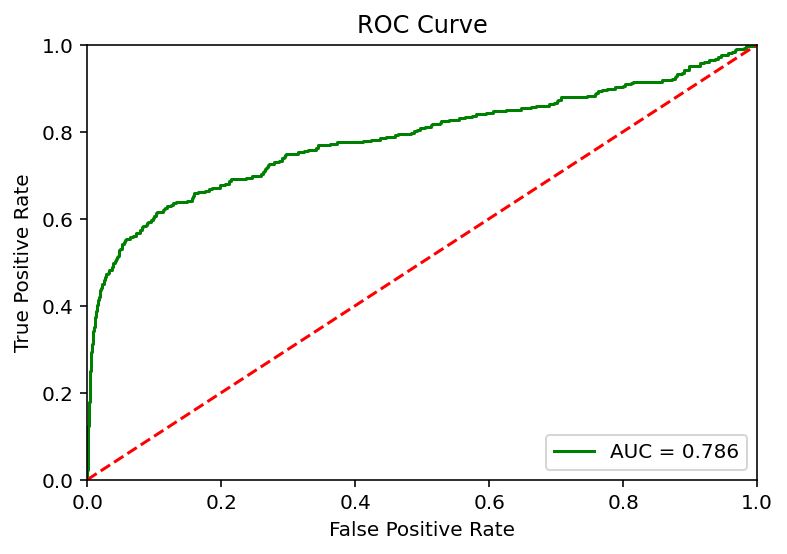

ROC AUC score: 0.7859


In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

eval_class(lr, X_test, y_test)


**References**:
 - Kaggle Datasets: LogP of Chemical Structures. https://www.kaggle.com/matthewmasters/chemical-structure-and-logp
 - Jaeger, S., Fulle, S., & Turk, S. (2018). Mol2vec: Unsupervised machine learning approach with chemical intuition. Journal of chemical information and modeling, 58(1), 27-35. URL = {http://dx.doi.org/10.1021/acs.jcim.7b00616}, eprint = {http://dx.doi.org/10.1021/acs.jcim.7b00616}
 - AIDS Antiviral Screen Data. https://wiki.nci.nih.gov/display/NCIDTPdata/AIDS+Antiviral+Screen+Data